# Evolutionary Design of Artificial Neural Networks
# Diseño Evolutivo de Redes Neuronales Artificiales
## Baseline
Based on the paper [Predicting Daily Returns of Global Stocks Indices: Neural Networks vs Support Vector Machines. Kaur, Dharni 2019](https://journaljemt.com/index.php/JEMT/article/view/30179)

This programs reproduces the paper results on ANN for DJI using data from Yahoo Finance. The technical indicators were calculated based on the paper formulas and the author advise.

Basado en el paper [Predicting Daily Returns of Global Stocks Indices: Neural Networks vs Support Vector Machines. Kaur, Dharni 2019](https://journaljemt.com/index.php/JEMT/article/view/30179)

Este programa reproduce los resultados del paper en ANN para el DJI usando datos obtenidos de Yahoo Finance. Se calcularon los indicadores técnicos según las fórmulas del paper y las indicaciones del autor.

### Libraries required

In [0]:
import numpy as np
import sklearn.preprocessing as skp
import tensorflow as tf
from matplotlib import pyplot as plt


### Configuration parameters

In [0]:
p = {
    "local_file": "baseline.csv",
    "url": "https://raw.githubusercontent.com/" +
           "jmacostap/webstore/master/baseline.csv",
    "cache_dir": "/content",
    "use_scaler": False,
    "scaler": skp.MinMaxScaler(),
    "test_fraction": 0.20,  # 20% of samples for test data
    "neurons": 9,
    "activation": "sigmoid",  # for the hidden layer
    "output_activation": "linear",  # for the output layer
    "optimizer": tf.keras.optimizers.SGD(
        learning_rate=0.3,
        momentum=0.2,
        nesterov=False),
    "metrics": ["mae", "mape"],
    "loss": "mse",  # could be mae or mse
    "epochs": 500,  # training epochs
    "batch_size": 100,
    "shuffle": True,  # the training data
    "verbose": 0,  # verbose training
    }

### Read data directly from my GitHub repository

In [48]:
path_to_downloaded_file = tf.keras.utils.get_file(
    p["local_file"],
    p["url"],
    cache_dir=p["cache_dir"],
    )
data = np.loadtxt(path_to_downloaded_file, skiprows=1, delimiter=",")
print(f"{data.shape} samples read")

# Extract targets
targets = np.reshape(data[:, -1], (-1, 1))
print(f"Targets to be used: {targets.shape}")

# Extract features
data = data[:, :-1]
print(f"Samples to be used: {data.shape}")

# Normalize data to [0,1]
if p["use_scaler"]:
    data_scaler = p["scaler"]
    data = data_scaler.fit_transform(data)
    targets_scaler = p["scaler"]
    targets = targets_scaler.fit_transform(targets)

# Reserve test data
test_fraction = np.int(len(data)*p["test_fraction"])
print(f"Test fraction: {test_fraction}")
train_targets = targets[:-test_fraction]
print(f"Train targets: {train_targets.shape}")
train_data = data[:-test_fraction]
print(f"Train samples: {train_data.shape}")
test_targets = targets[-test_fraction:]
print(f"Test targets: {test_targets.shape}")
test_data = data[-test_fraction:]
print(f"Test samples: {test_data.shape}")

(3022, 13) samples read
Targets to be used: (3022, 1)
Samples to be used: (3022, 12)
Test fraction: 604
Train targets: (2418, 1)
Train samples: (2418, 12)
Test targets: (604, 1)
Test samples: (604, 12)


### Create the model

In [49]:
# Ensure reproducibility
np.random.seed(31416)  # numpy
tf.random.set_seed(31416)  # keras

# Define the model
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            p["neurons"],
            activation=p["activation"],
            input_shape=(data.shape[1],),
        ),
        tf.keras.layers.Dense(
            1,
            activation=p["output_activation"],
        ),
    ]
)

# Create the model
model.compile(
    optimizer=p["optimizer"],
    metrics=p["metrics"],
    loss=p["loss"],
)
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 9)                 117       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 10        
Total params: 127
Trainable params: 127
Non-trainable params: 0
_________________________________________________________________
None


### Train the model

In [50]:
# Train the model
history = model.fit(
    train_data,
    train_targets,
    epochs=p["epochs"],
    batch_size=p["batch_size"],
    shuffle=p["shuffle"],
    verbose=p["verbose"],
    validation_split=p["test_fraction"],
    )
loss, mae, mape = model.evaluate(train_data, train_targets)
print(f"Train error: {loss}, MAE: {mae}, MAPE: {mape}")

76/76 [==============================] - 0s 1ms/step - loss: 1.4067e-04 - mae: 0.0078 - mape: 778.3638
Train error: 0.00014067365555092692, MAE: 0.007842998020350933, MAPE: 778.3638305664062


### Visualize training

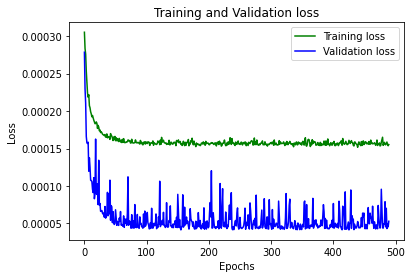

In [51]:
fro = 10  # Avoid autoscale issues
plt.plot(history.history['loss'][fro:], 'g', label='Training loss')
plt.plot(history.history['val_loss'][fro:], 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Test the trained model

In [52]:
loss_error, mae_error, mape_error = model.evaluate(test_data, test_targets)
print(f"Test error: {loss_error}, MAE: {mae_error}, MAPE: {mape_error}")

19/19 [==============================] - 0s 1ms/step - loss: 8.7892e-05 - mae: 0.0067 - mape: 3984.4119
Test error: 8.789224375505e-05, MAE: 0.006663620937615633, MAPE: 3984.411865234375


### Visualize predictions

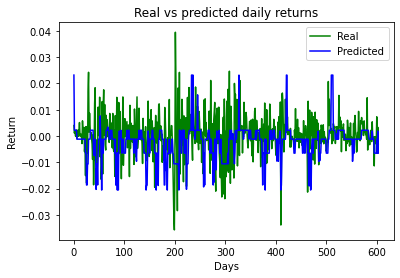

In [53]:
y_pred = model.predict(test_data)
plt.plot(test_targets, 'g', label='Real')
plt.plot(y_pred, 'b', label='Predicted')
plt.title('Real vs predicted daily returns')
plt.xlabel('Days')
plt.ylabel('Return')
plt.legend()
plt.show()